In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
import requests
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip folder in your Google Drive
zip_folder_path = '/content/drive/MyDrive/shoes60.zip'

# Destination directory to extract the contents of the zip folder
extract_dir = './data'

# Extract the zip folder
os.makedirs(extract_dir, exist_ok=True)
os.system(f'unzip "{zip_folder_path}" -d "{extract_dir}"')


Mounted at /content/drive


0

In [ ]:
print(os.listdir(extract_dir))

['shoes60']


In [ ]:
import os

def rename_images_with_serial_number(folder_path):
    if not os.path.isdir(folder_path):
        raise ValueError("Invalid folder path provided.")

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    # Sort the files to ensure consistent order
    file_list.sort()

    # Start the serial number from 1
    serial_number = 1

    for filename in file_list:
        # Check if the file is an image (you can add more image extensions if needed)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Create the new filename using the serial number
            new_filename = f"{serial_number:04d}.jpg"  # Use leading zeros for better sorting

            # Get the full paths for the old and new filenames
            old_filepath = os.path.join(folder_path, filename)
            new_filepath = os.path.join(folder_path, new_filename)

            # Rename the file
            os.rename(old_filepath, new_filepath)

            # Increment the serial number for the next file
            serial_number += 1

    print("Image renaming completed successfully.")




In [ ]:
rename_images_with_serial_number("/content/data/shoes60")

Image renaming completed successfully.


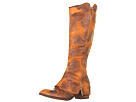

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image_path = "/content/data/shoes60/0001.jpg"  # Replace with the actual path to the image causing the error
image = cv2.imread(image_path)

if image is None:
    print(f"Failed to read image: {image_path}")
else:
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
import os
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from sklearn.cluster import KMeans

# Function to extract features from images using a pre-trained CNN model
def extract_features(images_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    model = models.resnet50(pretrained=True)
    model = model.eval()

    feature_vectors = []
    for image_path in images_path:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR, convert to RGB
        pil_image = Image.fromarray(image)  # Convert NumPy array to PIL image
        image = transform(pil_image).unsqueeze(0)  # Add a batch dimension

        with torch.no_grad():
            feature_vector = model(image)
            feature_vectors.append(feature_vector.squeeze().numpy())

    return feature_vectors

# Function to perform K-means clustering on feature vectors
def kmeans_clustering(feature_vectors, num_clusters=3):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(feature_vectors)
    return kmeans.labels_

# Function to move images to their corresponding subdirectories
def move_images_to_subdirectories(image_paths, labels, output_dir):
    for label, image_path in zip(labels, image_paths):
        category = 'shoes' if label == 0 else 'boots' if label == 1 else 'sandals'
        destination_dir = os.path.join(output_dir, category)
        os.makedirs(destination_dir, exist_ok=True)

        # Extract the image filename from the full path
        image_filename = os.path.basename(image_path)
        destination_path = os.path.join(destination_dir, image_filename)

        # Move the image to the corresponding subdirectory
        os.rename(image_path, destination_path)



In [ ]:
# Main function
def main():
    # Path to the directory containing all the images
    images_directory = "/content/data/shoes60"

    # Path to the output directory where the images will be separated into subdirectories
    output_directory = "/content/data/separated_folders"

    # Extract features from the images
    image_paths = [os.path.join(images_directory, image_file) for image_file in os.listdir(images_directory)]
    feature_vectors = extract_features(image_paths)

    # Perform K-means clustering
    num_clusters = 3  # Three clusters for shoes, boots, and sandals
    labels = kmeans_clustering(feature_vectors, num_clusters)

    # Move images to their corresponding subdirectories
    move_images_to_subdirectories(image_paths, labels, output_directory)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 85.0MB/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly